In [10]:
import numpy as np
!pip install gymnasium
import gymnasium as gym
!pip install ale_py
import ale_py
import sys
import pylab
import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from gymnasium import wrappers
from tqdm import tqdm

In [11]:
class DQN:
    def __init__(self, state_size, action_size, load_model=False):
        self.state_size = state_size
        self.action_size = action_size

        if load_model: # loading the model will disable training
            self.discount = 0.99
            self.learning_rate = 0.00001
            self.epsilon = 0.2 # exploring at 1 and exploiting at 0
            self.epsilon_decay = 0.99999
            self.epsilon_min = 0.2
        else:
            self.discount = 0.99
            self.learning_rate = 0.001
            self.epsilon = 1.0
            self.epsilon_decay = 0.9999
            self.epsilon_min = 0.1

        self.batch_size = 32
        self.train_start = 1000

        self.memory = deque(maxlen=2000)
        self.model = self.build_model()

        if load_model:
            self.model.load_weights('./results/pacman.h5')

    def build_model(self):
        model = Sequential()
        #model.add(Input(shape=(self.state_size,)))
        model.add(Input(shape=(84, 84, 1)))

        #model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        #model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        """model.add(Conv2D(32, (8, 8), strides=(4,4), activation='relu', kernel_initializer='he_uniform'))
        model.add(Conv2D(64, (4, 4), strides=(2,2), activation='relu', kernel_initializer='he_uniform'))
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
        model.add(Flatten())
        model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))

        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))"""

        """model.add(Conv2D(filters = 32,kernel_size = (8,8),strides = 4,data_format="channels_last", activation = 'relu',kernel_initializer = tf.keras.initializers.VarianceScaling(scale=2)))
        model.add(Conv2D(filters = 64,kernel_size = (4,4),strides = 2,data_format="channels_last", activation = 'relu',kernel_initializer = tf.keras.initializers.VarianceScaling(scale=2)))
        model.add(Conv2D(filters = 64,kernel_size = (3,3),strides = 1,data_format="channels_last", activation = 'relu',kernel_initializer = tf.keras.initializers.VarianceScaling(scale=2)))
        model.add(Flatten())
        model.add(Dense(512,activation = 'relu', kernel_initializer = tf.keras.initializers.VarianceScaling(scale=2)))
        model.add(Dense(len(self.action_size), activation = 'linear'))"""

        model.add(Conv2D(32, (8, 8), strides=4, activation='relu', kernel_initializer='he_uniform', ))
        model.add(Conv2D(64, (4, 4), strides=2, activation='relu', kernel_initializer='he_uniform', ))
        model.add(Conv2D(64, (3, 3), strides=1, activation='relu', kernel_initializer='he_uniform', ))
        model.add(Flatten())
        model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))

        model.add(Dense(self.action_size, activation='linear', kernel_initializer='he_uniform'))

        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        model.summary()
        return model

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            with tf.device(device):
                act_values = self.model.predict(state, verbose=0) # get the Q-values for the state
            return np.argmax(act_values[0]) # return the action with the highest Q-value

    def append_memory(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        # if self.epsilon > self.epsilon_min:
        #     self.epsilon *= self.epsilon_decay

    def experience_replay(self): # experience replay
        # if len(self.memory) < self.train_start:
        #     return
        if len(self.memory) < self.batch_size:
            return

        #batch_size = min(len(self.memory), self.batch_size)
        #batch_size = self.batch_size
        minibatch = random.sample(self.memory, self.batch_size)

        #state = np.zeros((batch_size, self.state_size))
        #next_state = np.zeros((batch_size, self.state_size))
        state = np.zeros((self.batch_size, 84, 84, 1))
        next_state = np.zeros((self.batch_size, 84, 84, 1))

        action, reward, done = [], [], []

        for i in range(self.batch_size):
            state[i] = minibatch[i][0].reshape((84, 84, 1))
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            next_state[i] = minibatch[i][3].reshape((84, 84, 1))
            done.append(minibatch[i][4])

        with tf.device(device):
            target = self.model.predict(state, verbose=0)
            target_next = self.model.predict(next_state, verbose=0)

        for i in range(self.batch_size):
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.discount * np.amax(target_next[i])
        with tf.device(device):
            self.model.fit(state, target, batch_size=self.batch_size, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [12]:
n_episodes = 120
environment = 'ALE/Pacman-v5'
path_training = './DQN/results/'
path_training = '/kaggle/working/'

from google.colab import drive
drive.mount('/content/drive')
path_training = '/content/drive/MyDrive/'

gym.register_envs(ale_py)
device = '/GPU:0' if tf.config.experimental.list_physical_devices('GPU') else '/CPU:0'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
class Pacman:
    def __init__(self, mode, view):
        self.env = gym.make(environment, frameskip=1, render_mode=view) # rgb_array or human
        self.env.reset()
        size_state = self.env.observation_space.shape[0]
        size_action = self.env.action_space.n

        # network construction
        if mode.lower() == 'test':
            load_model = True
        else:
            load_model = False

        #self.agent = DQN(size_state, size_action, load_model)
        self.agent = DQN((84, 84, 1), size_action, load_model)

    def train(self, path, statistics, mode):
        if path:
            train_path = path
        else:
            train_path = path_training

        if statistics:
            print('Scores will be plotted')
        else:
            print('Scores will not be plotted')

        env = self.env
        env = wrappers.AtariPreprocessing(env, frame_skip=4, grayscale_obs=True, screen_size=84)

        agent = self.agent

        size_state = self.env.observation_space.shape[0]
        scores, episodes = [], []

        scaler = tf.keras.layers.Rescaling(1./255)

        for e in tqdm(range(n_episodes)):
            done = False
            score = 0
            state, _ = env.reset()
            #state = np.reshape(state, [1, size_state])
            state = np.expand_dims(state, axis=-1) # 84x84x1 now
            state = np.moveaxis(state, 2, 0) / 255.0
            state = np.reshape(state, (1, 84, 84, 1))

            lives = 4
            while not done:
                dead = False
                while not dead:
                    action = agent.get_action(state)
                    next_state, reward, done, _, info = env.step(action)
                    #next_state = np.reshape(next_state, [1, size_state])
                    next_state = np.expand_dims(next_state, axis=-1)
                    next_state = np.moveaxis(next_state, 2, 0) / 255.0
                    next_state = np.reshape(next_state, (1, 84, 84, 1))

                    real_reward = reward
                    reward = reward if not dead else -10 # penalize deaths

                    agent.append_memory(state, action, reward, next_state, done)
                    agent.experience_replay()


                    state = next_state
                    score += real_reward
                    dead = info['lives'] < lives
                    lives = info['lives']
                    #reward = reward if not dead else -10 # penalize deaths

                if done:
                    scores.append(score)
                    episodes.append(e)
                    #agent.update_target_model()

                    if statistics:
                        pylab.plot(episodes, scores, 'b')
                        pylab.savefig(train_path + 'pacman.png')
                    print('episode: {}/{}, score: {}, epsilon: {:.2}'.format(e, episodes, score, agent.epsilon))

            if e%50 == 0 and mode.lower() == 'train': # save the model every 50 episodes
                agent.model.save_weights(train_path + 'pacman.weights.h5')
                print('Model saved')

In [26]:
# run the code
pacman = Pacman('train', 'rgb_array')

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 20, 20, 32)          │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 9, 9, 64)            │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │       1,606,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,680,549 (6.41 MB)

 Trainable params: 1,680,549 (6.41 MB)

 Non-trainable params: 0 (0.00 B)

Scores will be plotted


  1%|          | 1/120 [01:03<2:05:50, 63.45s/it]

episode: 0/[0], score: 20.0, epsilon: 0.96
Model saved


  2%|▏         | 2/120 [02:17<2:16:45, 69.54s/it]

episode: 1/[0, 1], score: 15.0, epsilon: 0.92


  2%|▎         | 3/120 [03:42<2:29:53, 76.86s/it]

episode: 2/[0, 1, 2], score: 12.0, epsilon: 0.88


  3%|▎         | 4/120 [04:50<2:21:54, 73.40s/it]

episode: 3/[0, 1, 2, 3], score: 17.0, epsilon: 0.85


  4%|▍         | 5/120 [06:02<2:19:28, 72.77s/it]

episode: 4/[0, 1, 2, 3, 4], score: 18.0, epsilon: 0.81


  5%|▌         | 6/120 [07:15<2:18:23, 72.84s/it]

episode: 5/[0, 1, 2, 3, 4, 5], score: 21.0, epsilon: 0.78


  6%|▌         | 7/120 [08:16<2:09:38, 68.84s/it]

episode: 6/[0, 1, 2, 3, 4, 5, 6], score: 13.0, epsilon: 0.75


  7%|▋         | 8/120 [09:14<2:02:24, 65.58s/it]

episode: 7/[0, 1, 2, 3, 4, 5, 6, 7], score: 11.0, epsilon: 0.73


  8%|▊         | 9/120 [10:25<2:04:19, 67.20s/it]

episode: 8/[0, 1, 2, 3, 4, 5, 6, 7, 8], score: 10.0, epsilon: 0.7


  8%|▊         | 10/120 [11:42<2:08:32, 70.12s/it]

episode: 9/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], score: 19.0, epsilon: 0.67


  9%|▉         | 11/120 [12:55<2:09:25, 71.24s/it]

episode: 10/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], score: 15.0, epsilon: 0.65


 10%|█         | 12/120 [14:26<2:18:32, 76.97s/it]

episode: 11/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], score: 24.0, epsilon: 0.62


 11%|█         | 13/120 [16:05<2:29:23, 83.77s/it]

episode: 12/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], score: 24.0, epsilon: 0.59


 12%|█▏        | 14/120 [18:00<2:44:52, 93.33s/it]

episode: 13/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], score: 33.0, epsilon: 0.55


 12%|█▎        | 15/120 [19:41<2:46:55, 95.38s/it]

episode: 14/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], score: 31.0, epsilon: 0.53


 13%|█▎        | 16/120 [21:29<2:52:13, 99.36s/it]

episode: 15/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], score: 87.0, epsilon: 0.5


 14%|█▍        | 17/120 [23:05<2:48:38, 98.24s/it]

episode: 16/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], score: 43.0, epsilon: 0.48


 15%|█▌        | 18/120 [25:12<3:02:01, 107.07s/it]

episode: 17/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], score: 34.0, epsilon: 0.45


 16%|█▌        | 19/120 [26:39<2:50:01, 101.01s/it]

episode: 18/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], score: 14.0, epsilon: 0.43


 17%|█▋        | 20/120 [28:06<2:41:00, 96.61s/it] 

episode: 19/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], score: 20.0, epsilon: 0.41


 18%|█▊        | 21/120 [29:13<2:24:53, 87.81s/it]

episode: 20/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], score: 9.0, epsilon: 0.4


 18%|█▊        | 22/120 [31:29<2:47:08, 102.33s/it]

episode: 21/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], score: 167.0, epsilon: 0.37


 19%|█▉        | 23/120 [32:43<2:31:51, 93.93s/it] 

episode: 22/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], score: 9.0, epsilon: 0.36


 20%|██        | 24/120 [34:01<2:22:13, 88.89s/it]

episode: 23/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], score: 14.0, epsilon: 0.34


 21%|██        | 25/120 [35:00<2:06:35, 79.95s/it]

episode: 24/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], score: 8.0, epsilon: 0.33


 22%|██▏       | 26/120 [36:18<2:04:22, 79.39s/it]

episode: 25/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], score: 18.0, epsilon: 0.32


 22%|██▎       | 27/120 [37:28<1:58:46, 76.62s/it]

episode: 26/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26], score: 15.0, epsilon: 0.31


 23%|██▎       | 28/120 [39:48<2:26:41, 95.67s/it]

episode: 27/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27], score: 48.0, epsilon: 0.29


 24%|██▍       | 29/120 [41:21<2:24:02, 94.98s/it]

episode: 28/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28], score: 22.0, epsilon: 0.28


 25%|██▌       | 30/120 [42:57<2:22:56, 95.30s/it]

episode: 29/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], score: 21.0, epsilon: 0.26


 26%|██▌       | 31/120 [44:40<2:24:34, 97.46s/it]

episode: 30/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], score: 26.0, epsilon: 0.25


 27%|██▋       | 32/120 [45:47<2:09:23, 88.22s/it]

episode: 31/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], score: 12.0, epsilon: 0.24


 28%|██▊       | 33/120 [47:24<2:11:58, 91.01s/it]

episode: 32/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32], score: 25.0, epsilon: 0.23


 28%|██▊       | 34/120 [48:47<2:07:00, 88.61s/it]

episode: 33/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], score: 15.0, epsilon: 0.22


 29%|██▉       | 35/120 [50:07<2:01:41, 85.90s/it]

episode: 34/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34], score: 17.0, epsilon: 0.21


 30%|███       | 36/120 [51:56<2:09:54, 92.79s/it]

episode: 35/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], score: 33.0, epsilon: 0.2


 31%|███       | 37/120 [53:13<2:01:52, 88.11s/it]

episode: 36/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36], score: 13.0, epsilon: 0.2


 32%|███▏      | 38/120 [54:20<1:52:02, 81.99s/it]

episode: 37/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37], score: 6.0, epsilon: 0.19


 32%|███▎      | 39/120 [56:24<2:07:29, 94.44s/it]

episode: 38/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38], score: 38.0, epsilon: 0.18


 33%|███▎      | 40/120 [58:02<2:07:17, 95.47s/it]

episode: 39/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39], score: 17.0, epsilon: 0.17


 34%|███▍      | 41/120 [59:40<2:06:34, 96.13s/it]

episode: 40/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40], score: 20.0, epsilon: 0.16


 35%|███▌      | 42/120 [1:01:23<2:07:39, 98.21s/it]

episode: 41/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41], score: 23.0, epsilon: 0.16


 36%|███▌      | 43/120 [1:03:59<2:28:21, 115.61s/it]

episode: 42/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42], score: 53.0, epsilon: 0.14


 37%|███▋      | 44/120 [1:05:34<2:18:30, 109.35s/it]

episode: 43/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43], score: 21.0, epsilon: 0.14


 38%|███▊      | 45/120 [1:07:48<2:26:10, 116.94s/it]

episode: 44/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44], score: 26.0, epsilon: 0.13


 38%|███▊      | 46/120 [1:09:05<2:09:17, 104.83s/it]

episode: 45/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], score: 12.0, epsilon: 0.13


 39%|███▉      | 47/120 [1:10:21<1:57:03, 96.21s/it] 

episode: 46/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46], score: 11.0, epsilon: 0.12


 40%|████      | 48/120 [1:11:51<1:53:21, 94.47s/it]

episode: 47/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47], score: 18.0, epsilon: 0.12


 41%|████      | 49/120 [1:13:16<1:48:13, 91.45s/it]

episode: 48/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48], score: 12.0, epsilon: 0.11


 42%|████▏     | 50/120 [1:15:49<2:08:21, 110.02s/it]

episode: 49/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], score: 35.0, epsilon: 0.1
episode: 50/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50], score: 12.0, epsilon: 0.1


 42%|████▎     | 51/120 [1:17:33<2:04:20, 108.13s/it]

Model saved


 43%|████▎     | 52/120 [1:19:31<2:05:57, 111.13s/it]

episode: 51/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51], score: 28.0, epsilon: 0.1


 44%|████▍     | 53/120 [1:20:57<1:55:41, 103.60s/it]

episode: 52/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52], score: 10.0, epsilon: 0.1


 45%|████▌     | 54/120 [1:22:27<1:49:36, 99.65s/it] 

episode: 53/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53], score: 11.0, epsilon: 0.1


 46%|████▌     | 55/120 [1:24:03<1:46:38, 98.44s/it]

episode: 54/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54], score: 20.0, epsilon: 0.1


 47%|████▋     | 56/120 [1:25:36<1:43:10, 96.73s/it]

episode: 55/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55], score: 22.0, epsilon: 0.1


 48%|████▊     | 57/120 [1:27:25<1:45:32, 100.52s/it]

episode: 56/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56], score: 16.0, epsilon: 0.1


 48%|████▊     | 58/120 [1:29:12<1:45:48, 102.40s/it]

episode: 57/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57], score: 26.0, epsilon: 0.1


 49%|████▉     | 59/120 [1:31:08<1:48:14, 106.47s/it]

episode: 58/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58], score: 18.0, epsilon: 0.1


 50%|█████     | 60/120 [1:33:28<1:56:30, 116.52s/it]

episode: 59/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59], score: 19.0, epsilon: 0.1


 51%|█████     | 61/120 [1:34:41<1:41:40, 103.40s/it]

episode: 60/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60], score: 15.0, epsilon: 0.1


 52%|█████▏    | 62/120 [1:36:01<1:33:22, 96.60s/it] 

episode: 61/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61], score: 16.0, epsilon: 0.1


 52%|█████▎    | 63/120 [1:37:26<1:28:30, 93.16s/it]

episode: 62/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62], score: 23.0, epsilon: 0.1


 53%|█████▎    | 64/120 [1:38:52<1:24:44, 90.79s/it]

episode: 63/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63], score: 12.0, epsilon: 0.1


 54%|█████▍    | 65/120 [1:41:24<1:40:01, 109.12s/it]

episode: 64/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64], score: 45.0, epsilon: 0.1


 55%|█████▌    | 66/120 [1:42:56<1:33:47, 104.22s/it]

episode: 65/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65], score: 18.0, epsilon: 0.1


 56%|█████▌    | 67/120 [1:45:08<1:39:27, 112.59s/it]

episode: 66/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66], score: 58.0, epsilon: 0.1


 57%|█████▋    | 68/120 [1:46:59<1:37:07, 112.07s/it]

episode: 67/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67], score: 18.0, epsilon: 0.1


 57%|█████▊    | 69/120 [1:48:37<1:31:33, 107.71s/it]

episode: 68/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68], score: 21.0, epsilon: 0.1


 58%|█████▊    | 70/120 [1:49:57<1:22:53, 99.48s/it] 

episode: 69/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69], score: 8.0, epsilon: 0.1


 59%|█████▉    | 71/120 [1:51:27<1:18:58, 96.70s/it]

episode: 70/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70], score: 16.0, epsilon: 0.1


 60%|██████    | 72/120 [1:52:46<1:13:03, 91.33s/it]

episode: 71/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71], score: 9.0, epsilon: 0.1


 61%|██████    | 73/120 [1:54:14<1:10:46, 90.35s/it]

episode: 72/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72], score: 20.0, epsilon: 0.1


 62%|██████▏   | 74/120 [1:55:51<1:10:38, 92.14s/it]

episode: 73/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73], score: 16.0, epsilon: 0.1


 62%|██████▎   | 75/120 [1:57:16<1:07:35, 90.12s/it]

episode: 74/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74], score: 6.0, epsilon: 0.1


 63%|██████▎   | 76/120 [1:58:30<1:02:33, 85.32s/it]

episode: 75/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75], score: 12.0, epsilon: 0.1


 64%|██████▍   | 77/120 [2:00:46<1:12:02, 100.51s/it]

episode: 76/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76], score: 19.0, epsilon: 0.1


 65%|██████▌   | 78/120 [2:01:51<1:02:56, 89.92s/it] 

episode: 77/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77], score: 9.0, epsilon: 0.1


 66%|██████▌   | 79/120 [2:03:22<1:01:42, 90.30s/it]

episode: 78/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78], score: 18.0, epsilon: 0.1


 67%|██████▋   | 80/120 [2:04:57<1:01:02, 91.57s/it]

episode: 79/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79], score: 12.0, epsilon: 0.1


 68%|██████▊   | 81/120 [2:06:32<1:00:13, 92.65s/it]

episode: 80/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80], score: 22.0, epsilon: 0.1


 68%|██████▊   | 82/120 [2:07:48<55:25, 87.50s/it]  

episode: 81/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81], score: 12.0, epsilon: 0.1


 69%|██████▉   | 83/120 [2:09:22<55:12, 89.53s/it]

episode: 82/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82], score: 18.0, epsilon: 0.1


 70%|███████   | 84/120 [2:11:04<56:00, 93.36s/it]

episode: 83/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83], score: 19.0, epsilon: 0.1


 71%|███████   | 85/120 [2:12:26<52:23, 89.80s/it]

episode: 84/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84], score: 15.0, epsilon: 0.1


 72%|███████▏  | 86/120 [2:13:56<51:02, 90.07s/it]

episode: 85/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85], score: 9.0, epsilon: 0.1


 72%|███████▎  | 87/120 [2:15:37<51:18, 93.28s/it]

episode: 86/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86], score: 17.0, epsilon: 0.1


 73%|███████▎  | 88/120 [2:16:46<45:54, 86.07s/it]

episode: 87/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87], score: 7.0, epsilon: 0.1


 74%|███████▍  | 89/120 [2:18:09<43:57, 85.07s/it]

episode: 88/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88], score: 8.0, epsilon: 0.1


 75%|███████▌  | 90/120 [2:20:32<51:17, 102.57s/it]

episode: 89/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89], score: 91.0, epsilon: 0.1


 76%|███████▌  | 91/120 [2:23:10<57:28, 118.93s/it]

episode: 90/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90], score: 41.0, epsilon: 0.1


 77%|███████▋  | 92/120 [2:24:36<50:55, 109.12s/it]

episode: 91/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91], score: 21.0, epsilon: 0.1


 78%|███████▊  | 93/120 [2:25:39<42:52, 95.27s/it] 

episode: 92/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92], score: 4.0, epsilon: 0.1


 78%|███████▊  | 94/120 [2:27:05<40:07, 92.60s/it]

episode: 93/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93], score: 6.0, epsilon: 0.1


 79%|███████▉  | 95/120 [2:29:09<42:26, 101.87s/it]

episode: 94/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94], score: 26.0, epsilon: 0.1


 80%|████████  | 96/120 [2:30:55<41:15, 103.15s/it]

episode: 95/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95], score: 21.0, epsilon: 0.1


 81%|████████  | 97/120 [2:32:47<40:37, 105.99s/it]

episode: 96/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96], score: 16.0, epsilon: 0.1


 82%|████████▏ | 98/120 [2:34:00<35:10, 95.94s/it] 

episode: 97/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97], score: 7.0, epsilon: 0.1


 82%|████████▎ | 99/120 [2:36:09<37:02, 105.85s/it]

episode: 98/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98], score: 38.0, epsilon: 0.1


 83%|████████▎ | 100/120 [2:37:50<34:49, 104.47s/it]

episode: 99/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], score: 16.0, epsilon: 0.1
episode: 100/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100], score: 12.0, epsilon: 0.1


 84%|████████▍ | 101/120 [2:39:13<30:59, 97.89s/it] 

Model saved


 85%|████████▌ | 102/120 [2:40:33<27:44, 92.49s/it]

episode: 101/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101], score: 10.0, epsilon: 0.1


 86%|████████▌ | 103/120 [2:42:19<27:24, 96.73s/it]

episode: 102/[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102], score: 15.0, epsilon: 0.1


 86%|████████▌ | 103/120 [2:42:41<26:51, 94.77s/it]


KeyboardInterrupt: 

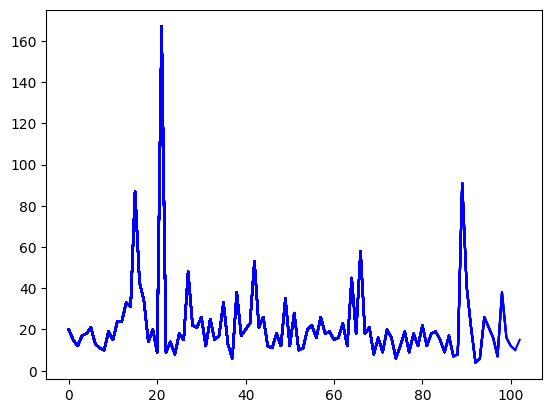

In [27]:
pacman.train(path=path_training, statistics=True, mode='train')